# Twitter Sentiment Analysis

### Initialisation

#### Import Libraries

In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer
from collections import Counter
from utils import build_freqs
import demoji
import string
import re
import warnings
warnings.filterwarnings("ignore")
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Rishabh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

#### Import Training Set

In [113]:
df_train = pd.read_csv("twitter_training.csv")
df_train.columns = ['TweetID','Entity','Sentiment','Content']
df_train.head(5)

,TweetID,Entity,Sentiment,Content
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


#### Import Testing Set

In [114]:
df_test = pd.read_csv("twitter_validation.csv")
df_test.columns = ['TweetID','Entity','Sentiment','Content']
df_test.head(5)

,TweetID,Entity,Sentiment,Content
0,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
1,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
2,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
3,4433,Google,Neutral,Now the President is slapping Americans in the...
4,6273,FIFA,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...


#### Missing Value Analysis

##### Before Removal

In [115]:
df_train.isnull().sum()

TweetID        0
Entity         0
Sentiment      0
Content      686
dtype: int64

After Removal

In [116]:
df_train.dropna(inplace=True)
df_train.isnull().sum()

TweetID      0
Entity       0
Sentiment    0
Content      0
dtype: int64

#### Remove Useless Attributes

In [117]:
df_test.drop(['TweetID','Entity'],axis=1,inplace=True)
df_train.drop(['TweetID','Entity'],axis=1,inplace=True)

#### DataFrames Samples 

In [118]:
df_train.tail()

,Sentiment,Content
74676,Positive,Just realized that the Windows partition of my...
74677,Positive,Just realized that my Mac window partition is ...
74678,Positive,Just realized the windows partition of my Mac ...
74679,Positive,Just realized between the windows partition of...
74680,Positive,Just like the windows partition of my Mac is l...


In [119]:
df_test.tail()

,Sentiment,Content
994,Irrelevant,⭐️ Toronto is the arts and culture capital of ...
995,Irrelevant,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...
996,Positive,Today sucked so it’s time to drink wine n play...
997,Positive,Bought a fraction of Microsoft today. Small wins.
998,Neutral,Johnson & Johnson to stop selling talc baby po...


#### Training Set Shape

In [120]:
df_train.shape

(73995, 2)

#### Testing Set Shape

In [121]:
df_test.shape

(999, 2)

### Exploratory Data Analysis

#### Train Dataset Distribution

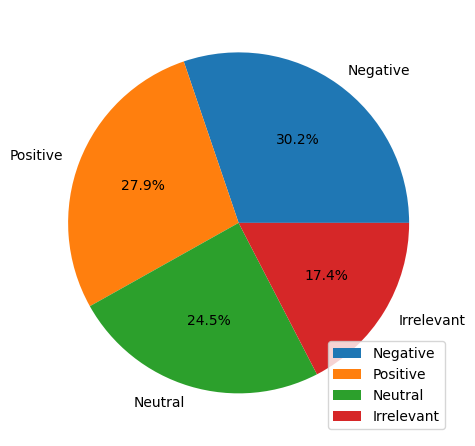

In [122]:
plt.figure(figsize=(5.5,7.5))
plt.pie(df_train['Sentiment'].value_counts(),autopct="%1.1f%%",labels=df_train['Sentiment'].value_counts().index)
plt.legend(loc='best')
plt.show()

#### Test Dataset Distribution

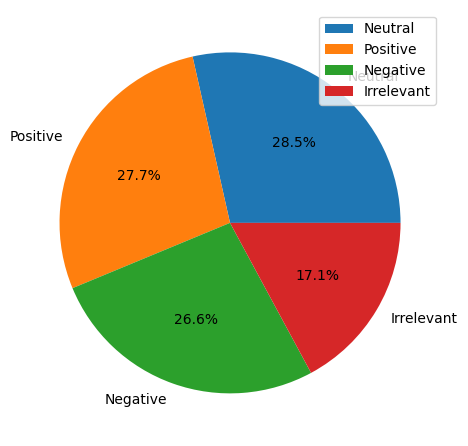

In [123]:
plt.figure(figsize=(5.5,7.5))
plt.pie(df_test['Sentiment'].value_counts(),autopct="%1.1f%%",labels=df_test['Sentiment'].value_counts().index)
plt.legend(loc='best')
plt.show()

### Training Wordcloud

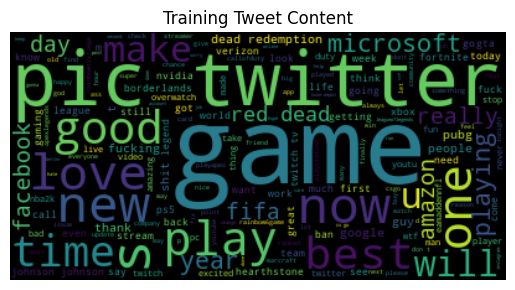

In [177]:
from wordcloud import WordCloud
wordcloud = WordCloud().generate(string)
string = ' '.join(tweet for tweet in df_train['Content'])
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis("off")
plt.title('Training Tweet Content')
plt.show()

#### Testing Wordcloud

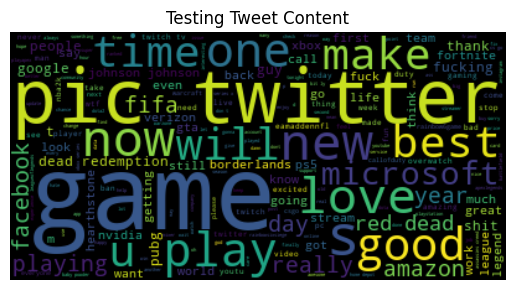

In [176]:
from wordcloud import WordCloud
wordcloud = WordCloud().generate(string)
string = ' '.join(tweet for tweet in df_test['Content'])
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis("off")
plt.title('Testing Tweet Content')
plt.show()

### Data Preprocessing

#### Hyperlink and Hashtag Removal

In [124]:
# Remove old style retweet text "RT"
df_train['Content'] = [re.sub(r'^RT[\s]+', '', str(tweet)) for tweet in df_train['Content']] 
df_test['Content'] = [re.sub(r'^RT[\s]+', '', str(tweet)) for tweet in df_test['Content']] 

# Remove hyperlinks
df_train['Content'] = [re.sub(r'https?://[^\s\n\r]+', '', tweet) for tweet in df_train['Content']]
df_test['Content'] = [re.sub(r'https?://[^\s\n\r]+', '', tweet) for tweet in df_test['Content']]

# Remove hashtag symbols
df_train['Content'] = [re.sub(r'#', '', tweet) for tweet in df_train['Content']]
df_test['Content'] = [re.sub(r'#', '', tweet) for tweet in df_test['Content']]

# Lowercase
df_train['Content'] = [str.lower(tweet) for tweet in df_train['Content']]
df_test['Content'] = [str.lower(tweet) for tweet in df_test['Content']]

# Remove emojis
df_train['Content'] = [demoji.replace(tweet,"") for tweet in df_train['Content']]
df_test['Content'] = [demoji.replace(tweet,"") for tweet in df_test['Content']]

df_test.tail()

,Sentiment,Content
994,Irrelevant,️ toronto is the arts and culture capital of c...
995,Irrelevant,this is actually a good move tot bring more vi...
996,Positive,today sucked so it’s time to drink wine n play...
997,Positive,bought a fraction of microsoft today. small wins.
998,Neutral,johnson & johnson to stop selling talc baby po...


#### Tokenizing

In [125]:
ttk = TweetTokenizer(preserve_case=False,reduce_len=True,strip_handles=True)

tweet_tokens = []

for tweet in df_train['Content']:
    for word in ttk.tokenize(tweet):
        tweet_tokens.append(word)
        
tweet_tokens = list(set(tweet_tokens))
            
print("Number of unique words: ", len(tweet_tokens))

Number of unique words:  39854


#### Removing Stopwords and Punctuation

In [126]:
clean_tokens = []

stop = stopwords.words('english') 
for word in tweet_tokens:
    if word not in string.punctuation and word not in stop and word[0]!='@':
        clean_tokens.append(word)
        
print("Length after removing stopwords and punctuations: ", len(clean_tokens))

Length after removing stopwords and punctuations:  39644


#### Stemming

In [127]:
stemmer = PorterStemmer()

stem_words = []
for word in clean_tokens:
    stemmed = stemmer.stem(word)
    stem_words.append(stemmed)

stem_words = list(set(stem_words))
print("Length after stemming: ", len(stem_words))

Length after stemming:  32902


#### Building Frequency Dictionary

In [128]:
freq_dict = build_freqs(tweets = df_train['Content'], ys = df_train['Sentiment'])

### Vectorization

#### Fit Transform Vectorization of the Training Dataset

In [136]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(df_train['Content'])
Y_train = df_train['Sentiment']

#### Transform Vectorization of the Testing Dataset

In [137]:
X_test = vectorizer.transform(df_test['Content'])
Y_test = df_test['Sentiment']

### Logistic Regression

#### Model Training

In [138]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver = 'lbfgs',max_iter=250)
model.fit(X_train,Y_train)

LogisticRegression(max_iter=500)

#### Model Testing

In [145]:
from sklearn.metrics import accuracy_score
Y_predict = model.predict(X_test)
print(f"Model Accuracy: {accuracy_score(Y_test,Y_predict).round(3)*100}%")

Model Accuracy: 95.5%


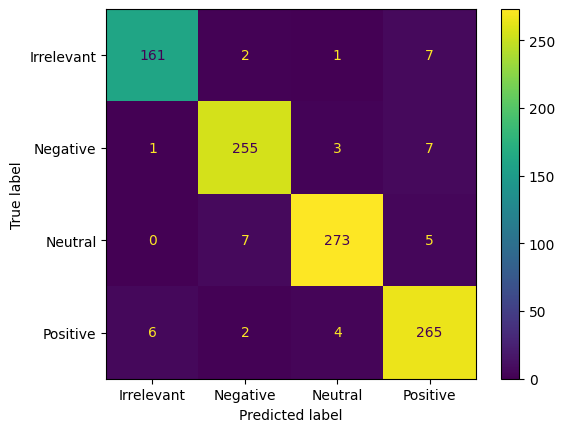

In [141]:
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(Y_test, Y_predict,labels=model.classes_)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = model.classes_)
cm_display.plot()
plt.show()

### User Input Prediction

In [152]:
tweet = input("Enter the tweet: ")
X = vectorizer.transform([tweet])
print(f"Predicted Sentiment: {model.predict(X)}")

Predicted Sentiment: ['Irrelevant']


### Pickling

In [179]:
import pickle

fm = open('model_pickle','wb')
pickle.dump(model,fm)

fv = open('vectorizer_pickle','wb')
pickle.dump(vectorizer,fv)